# Tutorial of Fairness Metrics for Healthcare

### Overview
This tutorial introduces methods and libraries for measuring fairness and bias in machine learning models as as they relate to problems in healthcare. Through the tutorial you will first learn some basic background about fairness and bias in machine learning. You will then generate a simple baseline model predicting Length of Stay (LOS) using data from the [MIMIC-III database](https://mimic.physionet.org/gettingstarted/access/), which you will use as an example to understand the most prominent fairness measures. You will also gain familiarity with [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/), two of the most comprehensive and flexible Python libraries for measuring and addressing bias in machine learning models.
  
### Tutorial Contents
[Part 0](#part0) - Background

[Part 1](#part1) - Model Setup

[Part 2](#part2) - Metrics of Fairness in AIF360

[Part 3](#part3) - Comparing Against a Second Model: Evaluating Unawarenes

[Part 4](#part4) - Testing Other Sensitive Attributes

[Part 5](#part5) - Comparison to FairLearn

### Tutorial Requirements
This tutorial assumes basic knowledge of machine learning implementation in Python. Before starting, please install [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/). Also, ensure that you have installed the Pandas, Numpy, Scikit, and XGBOOST libraries.

The tutorial also uses data from the MIMIC III Critical Care database, a freely accessible source of Electronic Health Records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/). Please save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location: you do not need to unzip any files.

## Part 0: Background <a class="anchor" id="part0"></a>
SECTIONS TO BE INCLUDED:
* what is fairness
* metrics for fairness (Explain Unawareness)
* list of measures that will be included in this notebook

## Part 1: Model Setup <a class="anchor" id="part1"></a>

This section introduces and loads the data subset that will be used in this tutorial. Then it generates a simple baseline model to be used throughout the tutorial.

In [7]:
# Standard Libraries
from IPython.display import Image
import numpy as np
import os
import pandas as pd
import sys

# Prediction Libraries
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

# Metrics
import sklearn.metrics as sk_metrics
from aif360.sklearn.metrics import *
from fairlearn.metrics import (
    selection_rate as fairlearn_selection_rate, 
    demographic_parity_difference, demographic_parity_ratio,
    balanced_accuracy_score_group_summary, roc_auc_score_group_summary,
    equalized_odds_difference, equalized_odds_ratio,
    difference_from_summary)

# Helpers from local folder
import tutorial_helpers

### MIMIC III Data Subset
As mentioned aboce, the MIMIC-III data download contains a folder of zipped_files. The tutorial code will automatically unzip and format all necessary data for these experiments, saving the formatted data in the MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [8]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

### Data Subset
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [9]:
df = tutorial_helpers.load_example_data(path_to_mimic_data_folder) 
df.head()

,ADMIT_ID,AGE,length_of_stay,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,...,PROCEDURE_CCS_221,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231
0,246679,65.0,1.144444,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,233587,70.0,5.496528,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,205685,75.0,6.768056,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,279025,70.0,6.988889,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,243933,75.0,5.364583,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


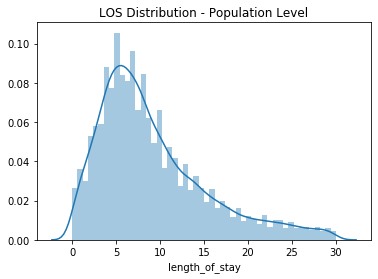

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.0,9.1152,6.2087,0.0042,4.7352,7.5799,12.0177,29.9889


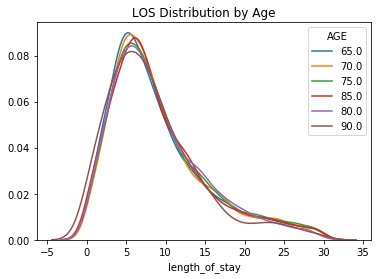

,count,mean,std,min,25%,50%,75%,max
AGE,,,,,,,,
65.0,4578.0,8.9994,6.2489,0.0694,4.5288,7.3000,11.9295,29.9792
70.0,4547.0,9.1939,6.2389,0.0493,4.8354,7.5819,11.9295,29.9660
75.0,4518.0,9.2912,6.3390,0.0458,4.7936,7.6781,12.3146,29.9410
80.0,4563.0,9.0917,6.0163,0.0049,4.7552,7.7250,12.1892,29.9681
85.0,3527.0,9.1152,6.2421,0.0042,4.8059,7.6292,12.0507,29.9889
90.0,701.0,8.3802,5.9091,0.0306,4.1194,7.0750,11.1056,29.6958


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


g = sns.distplot(df['length_of_stay'])
g.set_title('LOS Distribution - Population Level')
plt.show()
display(df[['length_of_stay']].describe().transpose().round(4))

for a in df.AGE.unique():
    f = sns.distplot(df.loc[df.AGE.eq(a), 'length_of_stay'], label=a, hist=False)
f.set_title('LOS Distribution by Age')
f.legend(title="AGE")
plt.show()
display(df.groupby('AGE')['length_of_stay'].describe().round(4))


### Baseline Length of Stay Model
Example models in this tutorial predict the length of time spent in the ICU, a.k.a. the "Length of Stay" (LOS). The baseline model will use only the patient's age, their diagnosis, and the use of medical procedures during their stay to predict this value. 

Two target variables will be used in the following experiments: 'length_of_stay' and 'los_binary'. For this dataset, length_of_stay is, of course, the true value of the length of the patient's stay in days. The los_binary variable is a binary variable indicating whether the admission resulted in a length of stay either < or >= the mean. We will generate variable below, and then generate our baseline model.

In [28]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
df['los_binary'] = df['length_of_stay'].apply(lambda x: 0 if x < mean_val else 1)
df[['length_of_stay', 'los_binary']].describe().transpose().round(4)

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.0,9.1152,6.2087,0.0042,4.7352,7.5799,12.0177,29.9889
los_binary,22434.0,0.3880,0.4873,0.0000,0.0000,0.0000,1.0000,1.0000


In [39]:
# Subset and Split Data
X = df.loc[:,['ADMIT_ID']+[c for c in df.columns if (c.startswith('AGE') or c.startswith('DIAGNOSIS_') or c.startswith('PROCEDURE_'))]]
y = df.loc[:, ['los_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

# Train Model
baseline_model = XGBClassifier()
baseline_model.fit(X_train, y_train.iloc[:,0])
baseline_y_pred = baseline_model.predict(X_test)
baseline_y_prob = baseline_model.predict_proba(X_test)[:, 1]

print('\n', "Baseline ROC_AUC Score:", sk_metrics.roc_auc_score(y_test.iloc[:,0], baseline_y_prob) )


 Baseline ROC_AUC Score: 0.8262079469098785


## Part 2: Testing Gender as a Sensitive Attribute <a class="anchor" id="part2"></a>
Our first experiment will test the effect of including the sensitive attribute 'GENDER_M'. This attribute is encoded in our data as a boolean attribute, where 0=female and 1=male, since males are assumed to be the privileged group. For the purposes of this experiment all other senstitive attributes and potential proxies will be dropped, such that only gender, age, diangosis, and procedure codes will be used to make the prediction.

First we will examine fairness measurements for a version of this model that includes gender as a feature, before comparing them to similar measurements for the baseline (without gender). We will see that while some measures can be used to analyze a model in isolation, others require comparison against other models.

In [43]:
df.groupby('GENDER_M')['length_of_stay'].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
GENDER_M,,,,,,,,
0,9987.0,9.1373,6.1984,0.0042,4.7507,7.6722,12.0667,29.9889
1,12447.0,9.0975,6.2171,0.0049,4.7149,7.4597,11.9729,29.9660


In [55]:
# Update Split Data to Include Gender as a Feature
X_train_gender = X_train.join(df[['GENDER_M']], how='inner')
X_test_gender = X_test.join(df[['GENDER_M']], how='inner')

# Train New Model with Gender Feature
gender_model = XGBClassifier()
gender_model.fit(X_train_gender, y_train.iloc[:,0])
y_pred_gender = gender_model.predict(X_test_gender)
y_prob_gender = gender_model.predict_proba(X_test_gender)

print('\n', "ROC_AUC Score with Gender Included:", sk_metrics.roc_auc_score(y_test.iloc[:,0], y_prob_gender[:,1]) )


 ROC_AUC Score with Gender Included: 0.8263658489688123


### Measuring Fairness via AIF360

AIF360 requires the sensitive attribute to be in the same dataframe (or 2-D array) as the target variable (both the ground truth and the prediction), so we add that here. Dataframes that have been formatted for the AIF360 Scikit API will be given the suffix "_aif".


In [49]:
y_test_aif = pd.concat([X_test_gender['GENDER_M'], y_test], axis=1).set_index('GENDER_M')
y_pred_aif = pd.concat([X_test_gender['GENDER_M'].reset_index(drop=True), pd.Series(y_pred_gender)], axis=1).set_index('GENDER_M')
y_pred_aif.columns = y_test_aif.columns

### Prediction Rates
The base rate is the average value of the ground truth (optionally weighted). It provides useful context, although it is not technically a measure of fairness. 
> $base\_rate = \sum_{i=0}^N(y_i)/N$

The Selection Rate is the average predicted value. For a binary prediction problem it equates to the probability of prediction for the positive class ("the probability of selection").
> $selection\_rate = \sum_{i=0}^N(ŷ_i)/N$

In [56]:
print("base_rate:", 
      base_rate(y_test_aif, y_pred_aif)
     )
print('selection_rate:', 
      selection_rate(y_test_aif, y_pred_aif)
     )

base_rate: 0.3880334954078876
selection_rate: 0.2724203133441383


### Measures of Demographic Parity

The Disparate Impact Ratio is the ratio between the probability of positive prediction for the unprivileged group and the probability of positive prediction for the privileged group. A ratio of 1 indicates that the model is fair relative to the sensitive attribute (it favors neither group).
> $disparate\_impact\_ratio = \dfrac{P(ŷ =1 | unprivileged)}{P(ŷ =1 | privileged)} = \dfrac{selection\_rate(ŷ_{unprivileged})}{selection\_rate(ŷ_{privileged})}$

Statistical Parity Difference is the difference in the probability of prediction between the two groups. A difference of 0 indicates that the model is fair relative to the sensitive attribute (it favors neither group).
> $statistical\_parity\_difference = P(ŷ =1 | unprivileged) - P(ŷ =1 | privileged) $

See also [Barocas (2016)](#barocas2016_ref)

In [57]:
print('disparate_impact_ratio', '\t', 
      disparate_impact_ratio(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )
print('statistical_parity_difference', '\t', 
      statistical_parity_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )

disparate_impact_ratio 	 1.024056122975343
statistical_parity_difference 	 0.006485295554100379


### Measures of Equal Odds
Average Odds Difference measures the average of the difference in False Positive Rate (FPR) and True Positive Rate (TPR) for the unprivileged and privileged groups. A difference of 1 indicates that the model is fair relative to the sensitive attribute.
> $ average\_odds\_difference = \dfrac{(FPR_{unprivileged} - FPR_{privileged})
        + (TPR_{unprivileged} - TPR_{privileged})}{2}$

Average Odds Error is the average of the absolute difference in FPR and TPR for the unprivileged and privileged groups. A difference of 1 indicates that the model is fair relative to the sensitive attribute.
> $average\_odds\_error = \dfrac{|FPR_{unprivileged} - FPR_{privileged}|
        + |TPR_{unprivileged} - TPR_{privileged}|}{2}$
        
Equal Opportunity Difference is the difference in recall scores (TPR) between the unprivileged and privileged groups. A difference of 0 indicates that the model is fair relative to the sensitive attribute.
> $equal\_opportunity\_difference =  Recall(ŷ_{unprivileged}) - Recall(ŷ_{privileged})$

See also [Zafar et. al. (2017)](#zafar2017_ref)

> to do: add range for interpretation (eg. "if positive, indicates that the privileged group is favored"

In [58]:
print('average_odds_difference', '\t', 
       average_odds_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M'))
print('average_odds_error', '\t', 
       average_odds_error(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )
print('equal_opportunity_difference', '\t', 
       equal_opportunity_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )

average_odds_difference 	 0.009169118657282704
average_odds_error 	 0.012270366404971533
equal_opportunity_difference 	 0.021439485062254238


### Predictive Rate Parity and Disparate Performance
<a id='aif_difference_func'></a>
Both of the libraries we will explore have added features to calculate custom, between-group differences in performance. An example use case 

In AIF360, this is facilitated by a flexible "difference" method that accepts an arbitrary scoring function as an argument. Here we use the function to demonstrate the Between-Group AUC Difference and Between-Group Balanced Accuracy Difference.

AIF360 also contains a "ratio" function of similar purpose. Here it's demonstrated with two arbitrary functions.

See also [Zafar et. al. (2017)](#zafar2017_ref)

In [59]:
# Examples Using the Difference Function
y_prob_gender = gender_model.predict_proba(X_test_gender)[:, 1]
print('Between-Group AUC Difference', '\t',
          difference(sk_metrics.roc_auc_score, y_test_aif, y_prob_gender, prot_attr='GENDER_M', priv_group=1)
     )
print('Between-Group Balanced Accuracy Difference', '\t',
          difference(sk_metrics.balanced_accuracy_score, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1)
     )

# Examples Using the Ratio Function
print('Predictive Parity Difference',
     )
print('Selection Rate Ratio (Disparate Impact Ratio)', 
        ratio(selection_rate, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1) 
     )
print('Recall Ratio', 
          ratio(sk_metrics.recall_score, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1) 
     )

Between-Group AUC Difference 	 0.0003299988657976538
Between-Group Balanced Accuracy Difference 	 0.012270366404971478
Predictive Parity Difference
Selection Rate Ratio (Disparate Impact Ratio) 1.024056122975343
Recall Ratio 1.0403610771113834


### Measures Of Individual Fairness
Consistency scores measure the similarity between a given prediction and the predictions of "like" individuals. In AIF360, the consistency score is calculated as the compliment of the mean distance to the score of the mean nearest neighbhor, using Scikit's Nearest Neighbors algorithm (default 5 neighbors determined by BallTree algorithm).
> $ consistency\_score = 1 - |mean_{distance}(mean({nearest\ neighbor}) )| $

#### The Generalized Entropy Index and Related Measures
The Generalized Entropy (GE) Index is...
> $ GE =  \mathcal{E}(\alpha) = \begin{cases}
            \frac{1}{n \alpha (\alpha-1)}\sum_{i=1}^n\left[\left(\frac{b_i}{\mu}\right)^\alpha - 1\right],& \alpha \ne 0, 1,\\
            \frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu},& \alpha=1,\\
            -\frac{1}{n}\sum_{i=1}^n\ln\frac{b_{i}}{\mu},& \alpha=0.
        \end{cases}
        $

Generalized Entropy Error = Calculates the GE of the set of errors, i.e. 1 + (ŷ == pos_label) - (y == pos_label) 
> $ GE(Error) = b_i = \hat{y}_i - y_i + 1 $

Between Group Generalized Entropy Error = Calculates the GE of the set of mean errors for the two groups (privileged error & unprivileged error), weighted by the number of predictions in each group
> $ GE(Error_{group}) =  GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $

See also [Dwork (2012)](#dwork2012_ref)
> to do: refine this text and add interpretation

In [60]:
print('consistency_score', '\t',
      consistency_score(X_test_gender, y_pred_gender)
     )
print('generalized_entropy_error', '\t',
      generalized_entropy_error(y_test['los_binary'], y_pred_gender)
     )
print('between_group_generalized_entropy_error', '\t',
      between_group_generalized_entropy_error(y_test_aif, y_pred_aif, prot_attr=['GENDER_M'])
     )

consistency_score 	 0.678633171258779
generalized_entropy_error 	 0.14548828649036535
between_group_generalized_entropy_error 	 6.320881285520908e-06


## Part 3: Comparing Against a Second Model - Evaluating Unawareness
<a class="anchor" id="part3"></a>

To demonstrate the change in model scores relative to the use of a sensitive attribute, we will compare the above scores to those of our baseline model. Although the GENDER_M feature is not included in our baseline, since we attached it to the y_test_aif dataframe above we can still evaluate it's bias relative to GENDER_M. As shown below, there is no significant difference in the scores of these two models. Therefore, the inclusion of GENDER_M as a feature does not contribute to gender bias for these models.

This tutorial includes a helper function which returns all of the previously-seen measures in a convenient pandas dataframe. Since we have already discussed the measures individuallly, we will use this function  to save space for the rest of the tutorial. 

In [61]:
# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Gender-Included Model, Relative to Patient Gender
gender_scores = tutorial_helpers.get_aif360_measures_df(X_test_gender, y_test, y_pred_gender, y_prob_gender, sensitive_attributes=['GENDER_M'])

# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Baseline Model, Relative to Patient Gender
baseline_scores = tutorial_helpers.get_aif360_measures_df(X_test_gender, y_test, baseline_y_pred, baseline_y_prob, sensitive_attributes=['GENDER_M'])

# Merge Results to Compare Values
comparison = gender_scores.rename(columns={'value':'gender_score'}
                                ).merge(baseline_scores.rename(columns={'value':'gender_score (feature removed)'}))
comparison.round(4)

,measure,gender_score,gender_score (feature removed)
0,selection_rate,0.2724,0.2727
1,disparate_impact_ratio,1.0241,1.0367
2,statistical_parity_difference,0.0065,0.0098
3,average_odds_difference,0.0092,0.0126
4,average_odds_error,0.0123,0.0126
5,equal_opportunity_difference,0.0214,0.0251
6,generalized_entropy_error,0.1455,0.1466
7,between_group_generalized_entropy_error,0.0000,0.0000
8,consistency_score,0.6786,0.6783
9,Between-Group AUC Difference,0.0003,-0.0002


## Part 4: Testing Other Sensitive Attributes

Our next experiment will test the presence of bias relative to a patient\'s language, assuming that there is a bias toward individuals who speak English. As above, we will add a boolean 'LANGUAGE_ENGL' feature to the baseline data.

In [62]:
# Update Split Data to Include Language as a Feature
lang_cols = [c for c in df.columns if c.startswith("LANGUAGE_")]
eng_cols = ['LANGUAGE_ENGL']
X_lang =  df.loc[:,lang_cols]
X_lang['LANG_ENGL'] = 0
X_lang.loc[X_lang[eng_cols].eq(1).any(axis=1), 'LANG_ENGL'] = 1
X_lang = X_lang.drop(lang_cols, axis=1).fillna(0)

# Show LOS Statistics Relative to LANG_ENGL
X_lang.join(df['length_of_stay']).groupby('LANG_ENGL')['length_of_stay'].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
LANG_ENGL,,,,,,,,
0,10266.0,9.5874,6.4989,0.0042,4.9115,7.9167,12.8132,29.9792
1,12168.0,8.7169,5.9239,0.0049,4.4819,7.2174,11.6069,29.9889


In [63]:
# Train New Model with Language Feature
X_lang_train = X_train.join(X_lang, how='inner')
X_lang_test = X_test.join(X_lang, how='inner')
lang_model = XGBClassifier()
lang_model.fit(X_lang_train, y_train.iloc[:,0])
y_pred_lang = lang_model.predict(X_lang_test)
y_prob_lang = lang_model.predict_proba(X_lang_test)

Again, by comparing the results with and without the sensitivie attribute we can better demonstrate the effect that the attribute has on the fairness of the model. In this example we see

In [64]:
# Generate Dataframe of  Measure Values for Language-Inclusive Model, Relative to Patient Language
print("Measure Values with LANG_ENGL Included:")
lang_scores = tutorial_helpers.get_aif360_measures_df(X_lang_test, y_test, y_pred_lang, y_prob_lang, sensitive_attributes=['LANG_ENGL'])
print(lang_scores.round(4).head(3))

# Generate Dataframe of Measure Values for Baseline Model, Relative to Patient Language
print("\n", "Measure Values with LANG_ENGL Removed:")
lang_ko_scores = tutorial_helpers.get_aif360_measures_df(X_lang_test, y_test, baseline_y_pred, baseline_y_prob, sensitive_attributes=['LANG_ENGL']) 
print(lang_ko_scores.round(4).head(3))

Measure Values with LANG_ENGL Included:
                         measure   value
0                 selection_rate  0.2685
1         disparate_impact_ratio  1.1774
2  statistical_parity_difference  0.0441

 Measure Values with LANG_ENGL Removed:
                         measure   value
0                 selection_rate  0.2727
1         disparate_impact_ratio  1.1109
2  statistical_parity_difference  0.0288


### Comparing All Four Models Against Each Other
The table below presents the measure values of all four models for comparison. As the table shows,  [[Conclusion based on comparison of models]]

> to do: validate this conclusion after fixing the issue with LOS <- currently the average LOS in the dataset is still higher than expected

> to do: find a new feature that shows a greater difference in fairness scores

In [65]:
# Merge Results to Display a Full Comparison
full_comparison = comparison.merge(lang_scores.rename(columns={'value':'lang_score'})
                            ).merge(lang_ko_scores.rename(columns={'value':'lang_score (feature removed)'})
                            )
full_comparison.round(4)

,measure,gender_score,gender_score (feature removed),lang_score,lang_score (feature removed)
0,selection_rate,0.2724,0.2727,0.2685,0.2727
1,disparate_impact_ratio,1.0241,1.0367,1.1774,1.1109
2,statistical_parity_difference,0.0065,0.0098,0.0441,0.0288
3,average_odds_difference,0.0092,0.0126,0.0190,0.0031
4,average_odds_error,0.0123,0.0126,0.0190,0.0033
5,equal_opportunity_difference,0.0214,0.0251,0.0184,-0.0002
6,generalized_entropy_error,0.1455,0.1466,0.1466,0.1466
7,between_group_generalized_entropy_error,0.0000,0.0000,0.0000,0.0001
8,consistency_score,0.6786,0.6783,0.6817,0.6783
9,Between-Group AUC Difference,0.0003,-0.0002,0.0007,0.0008


## Part 5: Comparison to FairLearn <a class="anchor" id="part5"></a>

The FairLearn and AIF360 APIs for Scikit and XGBOOST models are very similar in user experience, and contain a similar set of measures as shown in the table below. Although the set of measures provided by AIF360 is more comprehensive, FairLearn does provide some measures that are unique. First we'll look at FairLearn measures that are also found in AIF360 before explaining the measures that are distinct. 

In [67]:
tutorial_helpers.print_table_of_measures()

AIF360  \
General Measures             Base Rate                                               Y   
                             Selection Rate                                          Y   
Group Fairness Measures      Demographic (Statistical) Parity Difference             Y   
                             Disparate Impact Ratio (Demographic Parity Ratio)       Y   
                             Generalized Between-Group Predictive Disparity ...      Y   
                             Average Odds Difference                                 Y   
                             Average Odds Error                                      Y   
                             Equalized Odds Difference                               -   
                             Equalized Odds Ratio                                    -   
Individual Fairness Measures Between-Group Generalized Entropy Error                 Y   
                             Generalized Entropy Index                               Y   
                             Generalized Entropy Error                               Y   
                             Coefficient of Variation                                Y   
                             Consistency Score                                       Y   

                                                                                FairLearn  
General Measures             Base Rate                                                  -  
                             Selection Rate                                             Y  
Group Fairness Measures      Demographic (Statistical) Parity Difference                Y  
                             Disparate Impact Ratio (Demographic Parity Ratio)          Y  
                             Generalized Between-Group Predictive Disparity ...         Y  
                             Average Odds Difference                                    -  
                             Average Odds Error                                         -  
                             Equalized Odds Difference                                  Y  
                             Equalized Odds Ratio                                       Y  
Individual Fairness Measures Between-Group Generalized Entropy Error                    -  
                             Generalized Entropy Index                                  -  
                             Generalized Entropy Error                                  -  
                             Coefficient of Variation                                   -  
                             Consistency Score                                          -

In [25]:
# Display Example Results for Measures that are Found in AIF360
print("Selection rate", 
      selection_rate(y_test, y_pred_lang) )
print("Demographic parity difference", 
      demographic_parity_difference(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))
print("Demographic parity ratio", 
      demographic_parity_ratio(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL'])) 

Selection rate 0.27039438141545113
Demographic parity difference 0.054553219850345586
Demographic parity ratio 0.8178916255964723


### Measures Specific to FairLearn
Two measures that are not present in AIF360 are the Equalized Odds Difference and the Equalized Odds Ratio. Similar to the Average Odds Difference and Average Odds Ratio found in AIF360, these are measures of disparate rates in prediction.

The Equalized Odds Difference is the greater between the difference in TPR and the difference in FPR. A value of 0 indicates that all groups have the same TPR, FPR, TNR, and FNR, and that the model is "fair" relative to the sensitive attribute.
> $ equalized\_odds\_difference = max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$


The Equalized Odds Ratio is the smaller between the TPR Ratio and FPR Ratio, where the ratios are defined as the ratio of the smaller of the between-group rates vs the larger of the between-group rates.  A value of 1 means that all groups have the same TPR, FPR, TNR, and FNR.
> $ equalized\_odds\_ratio = min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$

In [23]:
print("Equalized Odds Difference",
        equalized_odds_difference(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))
print("Equalized Odds Ratio",
        equalized_odds_ratio(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))

Equalized Odds Difference 0.05159445477325997
Equalized Odds Ratio 0.7831711964697623


### Group Summaries
Similar to AIF360's "difference", which we used [above](#aif_difference_func) to calculate differences in prediction scores, FairLearn provides a "group_summary" function that returns a dictionary with both the overall and the between-group scores for a predictive metric. Also available are convenient wrappers, such as the "balanced_accuracy_score_group_summary" shown below which returns a summary of the balanced accuracy scores.

To extend the summary functionality, FairLearn also offers a "difference_from_summary" function (shown below), which calculates the between-group prediction difference (again, as we calculated [above](#aif_difference_func)).

In [24]:
balanced_accuracy_summary = balanced_accuracy_score_group_summary(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL'])
print("Balanced Accuracy Summary", balanced_accuracy_summary )
print("Between-Group Balanced Accuracy Difference", difference_from_summary(balanced_accuracy_summary) )

Balanced Accuracy Summary {'overall': 0.7227318124596438, 'by_group': {0: 0.7289100106775893, 1: 0.7155632936639851}}
Between-Group Balanced Accuracy Difference 0.013346717013604237


## Summary
This tutorial introduced multiple measures of ML fairness in the context of a healthcare model using the AIF360 and FairLearn Python libraries. A subset of the MIMIC-III database was used to generate a series of simple Length of Stay (LOS) models. It was shown that while the inclusion of a sensitive feature can significantly affect a model's bias as it relates to that feature, this is not always the case. 

# References 
<a id="barocas2016_ref"></a>
* Barocas S, & Selbst AD (2016). Big data's disparate impact. Calif. L. Rev., 104, 671. Available at [http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf](http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf) 

* Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943)
> See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

* Bird S, Dudík M,  Wallach H,  & Walker K (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Available at [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf)
> See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id="dwork2012_ref"></a>
* Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Available at [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf)

* Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Available at [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)

* Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, & Mark RG (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Available at [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)
    
<a id="zafar2017_ref"></a>
* Zafar MB, Valera I, Gomez Rodriguez, M, & Gummadi KP (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf